In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import time
import sampler
import display
import pprint

# Goal 1

In [150]:
def HouseholdDecomp(B):
    """
    inputs:
    B: np.array
        n x k matrix to be factored (with k <= n)

    returns Q, R
    Q: np.array
        n x k matrix
    R: np.array 
        k x k matrix
    """
    n, k = B.shape
    assert (n >= k), "n < k, precondition violated"
    
    Q = np.eye(n)
    R = B.copy().astype(float)
    for i in range(k):
        v = R[i : n, i].copy()
        v[0] += np.sign(v[0]) * np.linalg.norm(v)
        norm_v = np.linalg.norm(v)
        if norm_v == 0:
            continue
        v = v / norm_v
        v = v[ : , None]
        R[i : n, i : k] -= 2 * v @ (v.T @ R[i : n, i : k])
        Q[i : n, : ] -= 2 * v @ (v.T @ Q[i : n, : ])
        
    Q = Q[ : k].T
    R = R[ : k]
    assert (Q.shape == (n, k))
    assert (R.shape == (k, k))
    return Q, R

In [219]:
def QR_Facto(B):
    """
    inputs:
    B: np.array
        n x k matrix to be factored (with k <= n)

    returns R, H_vecs
    R: np.array 
        k x k matrix
    H_vecs: np.array
        array of householder vectors
    """
    n, k = B.shape
    assert (n >= k), "n < k, precondition violated"
    
    H_vecs = []
    R = B.copy().astype(float)
    for i in range(k):
        v = R[i : n, i].copy()
        v[0] = np.sign(v[0]) * np.linalg.norm(v) + v[0]
        norm_v = np.linalg.norm(v)
        if norm_v == 0: 
            H_vecs.append(v)
            continue
        v = v / norm_v
        v = v[ : , None]
        R[i : n, i : k] -= 2 * v @ (v.T @ R[i : n, i : k])
        H_vecs.append(v)
        
    R = R[ : k]
    assert (R.shape == (k, k))
    # assert (len(H_vecs) == k)
    return R, H_vecs

A = np.random.randint(10, size=(5,4))
Q_1, R_1 = HouseholdDecomp(A)
print("A: \n", A)
print("Q: \n", Q_1)
print("R: \n", R_1)
R_2, H_vecs = QR_Facto(A)
print("R: \n", R_2)
for i in range(len(H_vecs)):
    print("H_vecs[", i, "]: \n", H_vecs[i])

A: 
 [[1 6 4 0]
 [5 3 0 5]
 [7 0 5 6]
 [9 9 1 9]
 [4 3 1 5]]
Q: 
 [[-0.07624929  0.69225809 -0.68207755 -0.05361854]
 [-0.38124643 -0.04072106  0.28807825 -0.23562858]
 [-0.533745   -0.60176683 -0.57548185 -0.10577209]
 [-0.68624357  0.39363695  0.34474938 -0.20023448]
 [-0.30499714  0.04524563  0.04182869  0.9435691 ]]
R: 
 [[-1.31148770e+01 -8.69241851e+00 -3.96496283e+00 -1.28098799e+01]
 [ 0.00000000e+00  7.70985476e+00  1.99080757e-01 -4.52456265e-02]
 [ 0.00000000e+00 -8.88178420e-16 -5.21914137e+00  1.29938809e+00]
 [ 0.00000000e+00 -5.55111512e-17  4.44089210e-16  1.10295973e+00]]
R: 
 [[-1.31148770e+01 -8.69241851e+00 -3.96496283e+00 -1.28098799e+01]
 [ 0.00000000e+00  7.70985476e+00  1.99080757e-01 -4.52456265e-02]
 [ 0.00000000e+00 -8.88178420e-16 -5.21914137e+00  1.29938809e+00]
 [ 0.00000000e+00 -5.55111512e-17  4.44089210e-16  1.10295973e+00]]
H_vecs[ 0 ]: 
 [[0.73356979]
 [0.25985695]
 [0.36379974]
 [0.46774252]
 [0.20788556]]
H_vecs[ 1 ]: 
 [[-0.80185532]
 [-0.58930757]

## Householder Correctness

In [ ]:
def HouseholdTest(samples = 1000, tolerance = 1e-7):
    errors = 0
    for i in range(samples):
        A, (m, n) = sampler.r_mat_range(5, 50, 5, 50)
        if (m < n):
            A = A.T
        Q, R = HouseholdDecomp(A)
        if not np.allclose(Q @ R, A, atol=tolerance):
            errors += 1
    return errors

def QR_Test(samples = 1000, tolerance = 1e-7):
    errors = 0
    for i in range(samples):
        A, (m, n) = sampler.r_mat_range(5, 50, 5, 50)
        if (m < n):
            A = A.T
        R, H_vecs = QR_Facto(A)
        A_trans = A.copy()
        # consruct Q
        n, k = A.shape
        Q = np.eye(n)
        for i in range(len(H_vecs)):
            Q[i : n, : ] -= 2 * H_vecs[i] @ (H_vecs[i].T @ Q[i : n, : ])

        Q = Q[:k].T
        if not np.allclose(Q @ R, A, atol=tolerance):
            errors += 1
    return errors

In [229]:
# samples = 1000
# print (f'Error percentage: {HouseholdTest(samples) / samples}')
samples = 1000
print (f'Error percentage: {QR_Test(samples) / samples}')

Error percentage: 0.0


## Householder Scaling Analysis

### Scaling on random $m\times n$ matrices, $m\geq n$.

In [236]:
def compute_household_random(ns):
    times = []
    # every two is m,n pair
    _ns = []
    for m, n in zip(*[iter(ns)]*2):
        A = None
        if m > n:
            A = sampler.r_mat(m, n)
        else:
            A = sampler.r_mat(n, m)
        start = time.perf_counter_ns()
        # Q, R = HouseholdDecomp(A)
        Q, R = QR_Facto(A)
        end = time.perf_counter_ns()
        times.append(end - start)
        _ns.append(m * n * n)

    return _ns, times, (Q, R)

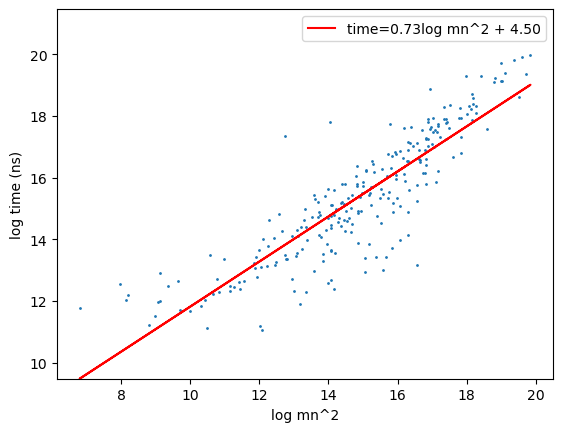

In [237]:
display.display(n_lo=5, n_hi=200, compute=compute_household_random, sampler="Exp", samples=500,axx_name="log mn^2", axy_name="log time (ns)", scientific=False)


### Scaling on random tall skinny $10n\times n$ matrices

In [238]:
def compute_household_skinny(ns):
    times = []
    _ns = []
    for n in ns:
        A = sampler.r_mat(10 * n, n)
        start = time.perf_counter_ns()
        # Q, R = HouseholdDecomp(A)
        Q, R = QR_Facto(A)
        end = time.perf_counter_ns()
        times.append(end - start)
        _ns.append(10 * n * n * n)

    return _ns, times, (Q,R)

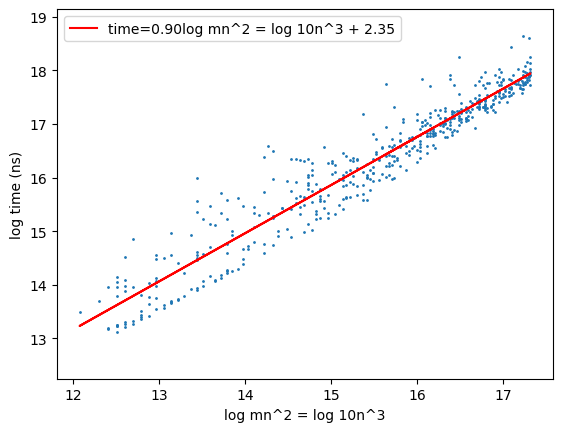

In [239]:
display.display(n_lo=25, n_hi=150, compute=compute_household_skinny, samples=500,axx_name="log mn^2 = log 10n^3", axy_name="log time (ns)", scientific=False)


### Scaling on random square $n\times n$ matrices

In [240]:
def compute_household_square(ns):
    times = []
    # every two is m,n pair
    for n in ns:
        A = sampler.r_square_mat(n)
        start = time.perf_counter_ns()
        # Q, R = HouseholdDecomp(A)
        Q, R = QR_Facto(A)
        end = time.perf_counter_ns()
        times.append(end - start)

    return ns, times, (Q,R)

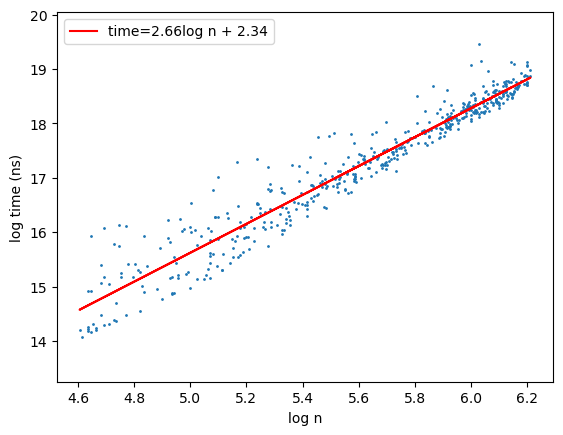

In [241]:
display.display(n_lo=100, n_hi=500, compute=compute_household_square, samples=500,axx_name="log n", axy_name="log time (ns)", scientific=False)

# Goal 2

## Algorithm 1: Alternating Least Squares, without regularization

In [291]:
def Apply_Householder(b, H_vecs):
    m = b.size
    d = b.copy()
    for i, v in enumerate(H_vecs):
        v_padded = np.zeros((m, 1))
        v_padded[i:, 0] = v.flatten()
        d = d - 2 * (v_padded.flatten() @ d) * v_padded.flatten()
    return d

def ALS(A, k, max_iter = 100, tolerance=1e-4):
    """
    A: n1 x n2 matrix
    k: int
        rank
    returns: W,Z
    """
    n1, n2 = A.shape
    W = sampler.r_mat(n1, k)
    Z = sampler.r_mat(n2, k)
    prev_norm = np.inf
    for _ in range(max_iter):
        # Qz, Rz = HouseholdDecomp(Z)
        # W = scipy.linalg.solve_triangular(Rz, Qz.T @ A.T, check_finite=False).T
        # Qw, Rw = HouseholdDecomp(W)
        # Z = scipy.linalg.solve_triangular(Rw, Qw.T @ A, check_finite=False).T
        # new_norm = np.linalg.norm(A - W @ Z.T, ord='fro') ** 2
        Rz, H_vecs_z = QR_Facto(Z)
        W = scipy.linalg.solve_triangular(Rz, Z.T @ A.T, check_finite=False).T
        Rw, H_vecs_w = QR_Facto(W)
        Z = scipy.linalg.solve_triangular(Rw, W.T @ A, check_finite=False).T
        new_norm = np.linalg.norm(A - W @ Z.T, ord='fro') ** 2
        if abs(new_norm - prev_norm) < tolerance:
            break
        prev_norm = new_norm
    return W, Z

# Goal 3

In [15]:
from PIL import Image

## Original image

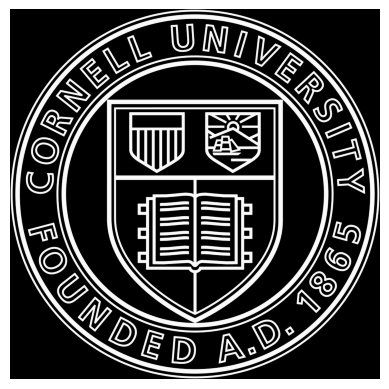

In [292]:
C = np.loadtxt('Data/Cornell.csv', delimiter=',')
k = 75
plt.imshow(C, cmap='Greys')
plt.axis('off')
plt.show()

## ALS Approximation

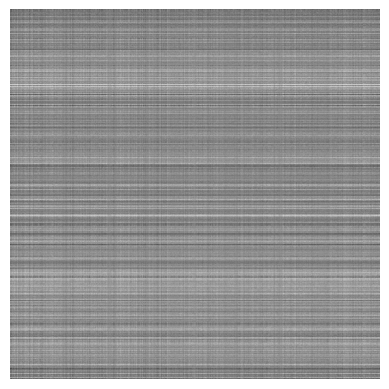

In [293]:
W,Z = ALS(C, k, max_iter=100)
plt.imshow(W @ Z.T, cmap='Greys')
plt.axis('off')
plt.show()

## SVD Approximation

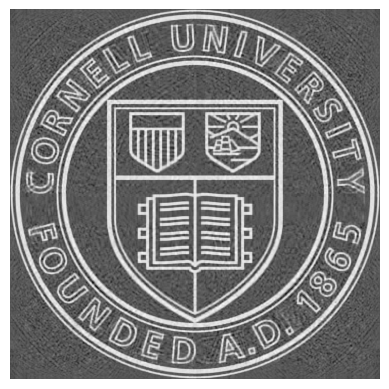

In [77]:
U,s,V = scipy.linalg.svd(C)
plt.imshow(U[ : , : k] @ np.diag(s[ : k]) @ V[ : k, : ], cmap='Greys')
plt.axis('off')
plt.show()

# Question 1

### Answer

# Goal 4

## Algorithm 2: Alternating Least Squares with regularization

In [289]:

def ALS_regularized(A, k, omega, beta, max_iter = 100, tolerance=1e-4):
    """
    A: n1 x n2 matrix
    k: int
    omega: mask matrix
    beta: float
    returns: W,Z
    """
    n1, n2 = A.shape
    W = sampler.r_mat(n1, k)
    Z = sampler.r_mat(n2, k)

    for it in range(max_iter):
        for j in range(n2):
            observed_rows, = np.where(omega[:,j] == 1)
            # print(observed_rows)
            if len(observed_rows) == 0:
                Z[j, :] = np.zeros(k)
            else:
                W_sub = W[observed_rows, :]
                A_sub = A[observed_rows, j]
                # print(W_sub.shape, A_sub.shape)
                # print((beta * np.eye(k)).shape, np.zeros(k).shape)
                M = np.vstack([W_sub, beta * np.eye(k)])
                b = np.concatenate([A_sub, np.zeros(k)])
                # Q, R = HouseholdDecomp(M)
                # Z[j, :] = scipy.linalg.solve_triangular(R, Q.T @ b, check_finite=False)
                R, H_vecs = QR_Facto(M)
                d = Apply_Householder(b, H_vecs)
                d = d[:R.shape[0]]
                Z[j, :] = scipy.linalg.solve_triangular(R, d, check_finite=False)

        for i in range(n1):
            observed_cols, = np.where(omega[i, :] == 1)
            if len(observed_cols) == 0:
                W[i, :] = np.zeros(k)
            else:
                Z_sub = Z[observed_cols, :]
                A_sub = A[i, observed_cols]
                M = np.vstack([Z_sub, beta * np.eye(k)])
                b = np.concatenate([A_sub, np.zeros(k)])
                # Q, R = HouseholdDecomp(M)
                # W[i, :] = scipy.linalg.solve_triangular(R, Q.T @ b, check_finite=False)
                R, H_vecs = QR_Facto(M)
                d = Apply_Householder(b, H_vecs)
                d = d[:R.shape[0]]
                W[i, :] = scipy.linalg.solve_triangular(R, d, check_finite=False)

    return W, Z

# Goal 5

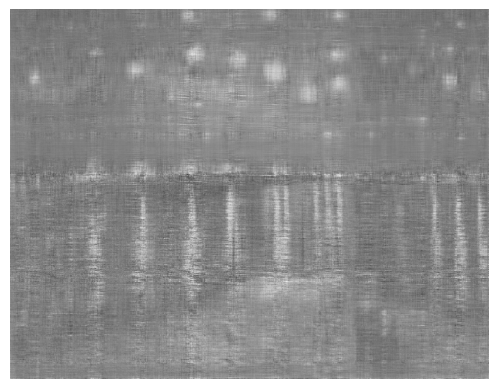

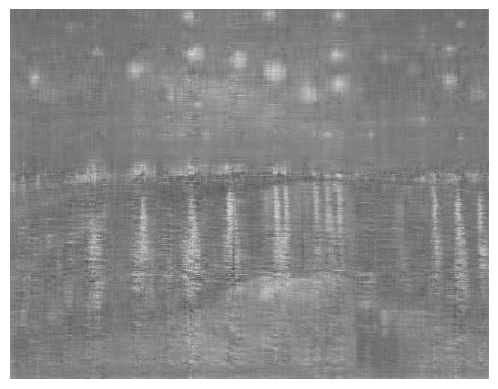

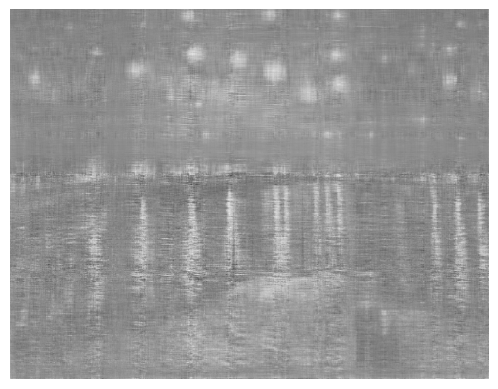

In [286]:
img1 = np.loadtxt('Data/Image1.csv', delimiter=',')
mask1 = np.loadtxt('Data/Mask1.csv', delimiter=',')
# print(mask1)
W1, Z1 = ALS_regularized(img1, 30, mask1, 0.3, max_iter=5) 
plt.imshow(W1 @ Z1.T, cmap='Greys_r')
plt.axis('off')
plt.show()

W1, Z1 = ALS_regularized(img1, 30, mask1, 0.3, max_iter=10) 
plt.imshow(W1 @ Z1.T, cmap='Greys_r')
plt.axis('off')
plt.show()

W1, Z1 = ALS_regularized(img1, 30, mask1, 0.3, max_iter=15) 
plt.imshow(W1 @ Z1.T, cmap='Greys_r')
plt.axis('off')
plt.show()

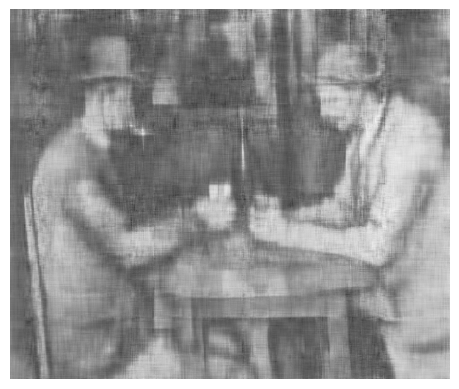

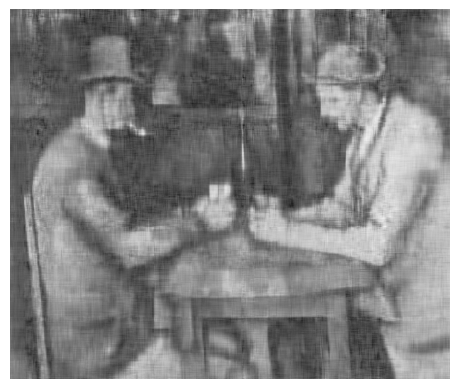

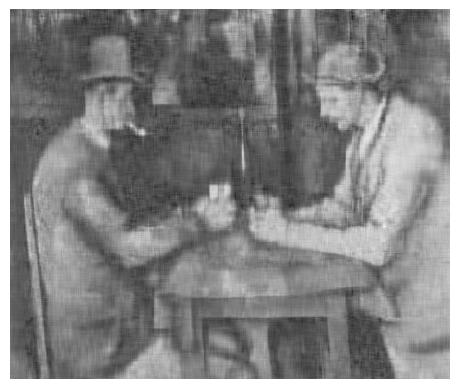

In [283]:
img2 = np.loadtxt('Data/Image2.csv', delimiter=',')
mask2 = np.loadtxt('Data/Mask2.csv', delimiter=',')
# plt.imshow(np.log(img2 * mask2 + 1) + 10000000, cmap='Greys')
# plt.imshow(img2 * mask2, cmap='Greys')
# plt.axis('off')
# plt.show()
W2, Z2 = ALS_regularized(img2, 30, mask2, 0.4, max_iter=5) 
plt.imshow(W2 @ Z2.T, cmap='Greys_r')
plt.axis('off')
plt.show()

W2, Z2 = ALS_regularized(img2, 30, mask2, 0.4, max_iter=10) 
plt.imshow(W2 @ Z2.T, cmap='Greys_r')
plt.axis('off')
plt.show()

W2, Z2 = ALS_regularized(img2, 30, mask2, 0.4, max_iter=20) 
plt.imshow(W2 @ Z2.T, cmap='Greys_r')
plt.axis('off')
plt.show()

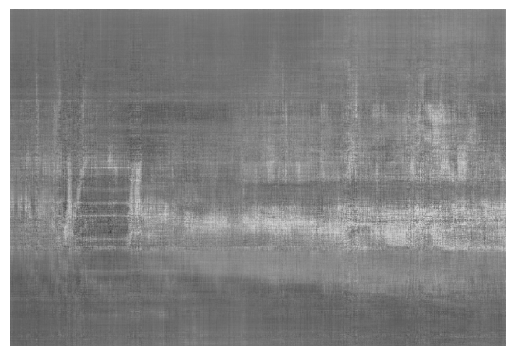

In [287]:
img3 = np.loadtxt('Data/Image3.csv', delimiter=',')
mask3 = np.loadtxt('Data/Mask3.csv', delimiter=',')

W3, Z3 = ALS_regularized(img3, 30, mask3, 0.3, max_iter=10)
plt.imshow(W3 @ Z3.T, cmap='Greys')
plt.axis('off')
plt.show()

In [17]:
## Goal 1: Testing
test_range = np.logspace(2, 10, num=200, base=2,dtype=int)
times = []

for n in test_range:
    B = np.random.rand(n, n-2)
    
    start_time = time.time()
    Householder_QR_Factorization(B)
    end_time = time.time()
    times.append(end_time - start_time)

# Log-transform the data
log_n = np.log(test_range)
log_time = np.log(times)

# Perform linear regression to estimate slope
slope1, intercept1, r_value1, _, _ = scipy.stats.linregress(log_n[:50], log_time[:50])
slope2, intercept2, r_value2, _, _ = scipy.stats.linregress(log_n[50:], log_time[50:])

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(log_n, log_time, label='Timing Data', color='blue')
plt.plot(log_n, intercept1 + slope1 * log_n, label=f'Fit Line 1 (slope = {slope1:.2f})', linestyle='--', color='red')
plt.plot(log_n, intercept2 + slope2 * log_n, label=f'Fit Line 2 (slope = {slope2:.2f})', linestyle='--', color='red')

plt.xlabel('log(n)', fontsize=12)
plt.ylabel('log(time)', fontsize=12)
plt.title('Log-Log Plot to Estimate Time Complexity', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

NameError: name 'Householder_QR_Factorization' is not defined